In [ ]:
# !pip install unidecode

     |████████████████████████████████| 245kB 5.8MB/s 


In [ ]:
import numpy as np 
import pandas as pd 


import os

import warnings  
warnings.filterwarnings('ignore')

# importing packages
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn packages
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier

# nltk packages
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation
import unidecode


#import os
#from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.feature_extraction.text import CountVectorizer
#import spacy
#import string
#import re
from google.colab import drive 
# import numpy as np
# import pandas as pd
# import plotly.express as px
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
#import nltk
#import operator
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = stopwords.words('english')
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/Shared drives/Capstone Team 15 Drive/Work/')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Mounted at /content/drive


In [ ]:
df = pd.read_csv("incident_download_Capstone_Project_2021-03-01.csv", encoding="ISO-8859-1")
df.head()

,u_affected_application,sys_created_on,resolved_at,calendar_duration,state,impact,urgency,priority,description,short_description,u_knowledge_id.u_ci_class,category,reopen_count,reassignment_count,comments_and_work_notes,u_ci_class_name,cause,close_notes,Unnamed: 18,1
0,Cisco AnyConnect,1/31/2021 23:56,2/1/2021 3:58,14580,Closed,4 - Minor,4 - Low,5 - Very Low,NaN,getting repeted sign-in dialogs in browser and...,NaN,Application,0,0,02-08-2021 04:34:31 - System (Additional comme...,Business Application,NaN,User connected to IDC two factor VPN and getti...,NaN,2
1,Driver,1/31/2021 23:54,2/1/2021 3:35,13287,Closed,4 - Minor,4 - Low,5 - Very Low,NaN,Wifi adapter not connecting to network.,NaN,Application,0,0,02-08-2021 04:33:30 - System (Additional comme...,Business Application,NaN,As taken remote we found WIFI drivers and BIOS...,NaN,3
2,Cisco AnyConnect,1/31/2021 23:53,2/1/2021 1:07,4509,Closed,4 - Minor,4 - Low,5 - Very Low,NaN,When im not on vpn my wifi speed is 40-50 Mbps...,NaN,Application,0,0,02-08-2021 01:36:40 - System (Additional comme...,Business Application,NaN,Requested user to use different Gateway of VPN...,NaN,4
3,Cisco AnyConnect,1/31/2021 23:48,2/1/2021 0:00,804,Closed,4 - Minor,4 - Low,5 - Very Low,NaN,"Lost me vpn google Authenticator key , how can...",NaN,Application,0,0,02-08-2021 00:33:09 - System (Additional comme...,Business Application,NaN,Google Authenticator enrolled,NaN,5
4,NaN,1/31/2021 23:42,2/1/2021 0:51,4151,Closed,4 - Minor,4 - Low,5 - Very Low,NaN,"Hi Team, I'm opening this service ticket on be...",NaN,Application,0,0,02-01-2021 00:51:27 - Santhosh Balu (Additiona...,Business Application,NaN,Issue resolved after connecting Wec 2 factor VPN,NaN,6


In [ ]:
for_tableau = pd.read_excel("for_tableau_2.xlsx")

In [ ]:
for_tableau['reassignment_count'] = df['reassignment_count']

In [ ]:
# for_tableau.to_excel('for_tableau_2.xlsx')

In [ ]:
df['calendar_duration']

0          14580
1          13287
2           4509
3            804
4           4151
           ...  
141027    813941
141028    203002
141029       164
141030     70529
141031    162073
Name: calendar_duration, Length: 141032, dtype: int64

In [ ]:
len(df)

141032

In [ ]:
def costum_tokenize(text):
  try:
    text = re.sub('\W+',' ', text)
    text = word_tokenize(text)
  except TypeError:
    text = 'NaN'
  
  return text

def freq_count(col):
  frq_dic = {}
  for lst in col:
    for i in lst:
      if i not in stop_words and i.isalpha():
        if i in frq_dic:
          frq_dic[i] += 1
        else:
          frq_dic[i] = 1
  return frq_dic

def split1(text):
  try:
    t = text[:19]
    return t
  except TypeError:
    return None

def split2(text):
  try:
    text = text[19:]
    return text
  except TypeError:
    return None

def clean_review(review):
    replace_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))   
    return review.translate(replace_punctuation).lower()

def remodel (text):
  return ' '.join(word_tokenize(clean_review(text)))
  

In [ ]:
df2 = df[['category', 'short_description']].dropna()
#,"comments_and_work_notes"

In [ ]:
df2['category'].value_counts()

Application               45674
Hardware                  21088
VDI                       19196
Access                    15019
Telephony                 10240
End user equipment         7456
Mobile Device              6874
Integration                3492
Printing                   2919
Network                    2656
Monitoring                 1807
Store equipment            1346
Security                   1204
AV / Conf room              675
Facilities                  525
Server                      309
Database                    181
Data / Reporting            100
Storage                      82
Middleware                   31
Enterprise Application        3
Name: category, dtype: int64

In [ ]:
def cleanText(text):
    text = re.sub('\W+',' ', text)
    text = text.lower()
    return ' '.join([t for t in text.split() if t not in stop_words])

df2['short_description'] = df2['short_description'].apply(cleanText)
#df2['comments_and_work_notes'] = df2['comments_and_work_notes'].apply(cleanText)

In [ ]:
# list of word types (nouns and adjectives) to leave in the text
defTags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJS', 'JJR']#, 'RB', 'RBS', 'RBR', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

# functions to determine the type of a word
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

# transform tag forms
def penn_to_wn(tag):
    if is_adjective(tag):
        return nltk.stem.wordnet.wordnet.ADJ
    elif is_noun(tag):
        return nltk.stem.wordnet.wordnet.NOUN
    elif is_adverb(tag):
        return nltk.stem.wordnet.wordnet.ADV
    elif is_verb(tag):
        return nltk.stem.wordnet.wordnet.VERB
    return nltk.stem.wordnet.wordnet.NOUN

# lemmatizer + tokenizer (+ stemming) class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        # we define (but not use) a stemming method, uncomment the last line in __call__ to get stemming tooo
        self.stemmer = nltk.stem.SnowballStemmer('english') 
    def __call__(self, doc):
        # pattern for numbers | words of length=2 | punctuations | words of length=1
        pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
        # tokenize document
        doc_tok = word_tokenize(doc)
        #filter out patterns from words
        doc_tok = [x for x in doc_tok if x not in stop_words]
        doc_tok = [pattern.sub('', x) for x in doc_tok]
        # get rid of anything with length=1
        doc_tok = [x for x in doc_tok if len(x) > 1]
        # position tagging
        doc_tagged = nltk.pos_tag(doc_tok)
        # selecting nouns and adjectives
        doc_tagged = [(t[0], t[1]) for t in doc_tagged if t[1] in defTags]
        # preparing lemmatization
        doc = [(t[0], penn_to_wn(t[1])) for t in doc_tagged]
        # lemmatization
        doc = [self.wnl.lemmatize(t[0], t[1]) for t in doc]
        # uncomment if you want stemming as well
        #doc = [self.stemmer.stem(x) for x in doc]
        return doc

In [ ]:
vec_tdidf = TfidfVectorizer(ngram_range=(1,1), analyzer='word', #stop_words=stop_words1, 
                                               norm='l2', tokenizer=LemmaTokenizer())

# Random Sampling cross validation

In [ ]:
# X = df2.drop(['category'], axis=1)
# y = df2['category']
# x_train, y_train, x_test, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
train, test = train_test_split(df2, test_size = 0.33, random_state=42)
x_train = vec_tdidf.fit_transform(train['short_description'])
x_test = vec_tdidf.transform(test['short_description'])
y_train = train['category']
y_test = test['category']

In [ ]:
import random

In [ ]:
#clf = XGBClassifier(random_state=42, objective="softmax")
m = int(train.shape[0]*0.3)

estimators = [50,100,150,200,300]

score = []
for i in range(5):
  new_train = train.sample(m)
  validation = train[~train.index.isin(new_train.index)]
  
  xtrain = vec_tdidf.fit_transform(new_train['short_description'])
  xval = vec_tdidf.transform(validation['short_description'])

  ytrain = new_train['category']
  yval = validation['category']
  
  acc_score = []
  for j in estimators:
    clf = XGBClassifier(random_state=42, n_estimators = j, objective="multi:softmax") #multi:softmax
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xval)
    acc = metrics.accuracy_score(yval, ypred)
    acc_score.append(acc)
  
  avg_score = np.mean(acc_score)
  score.append(avg_score)

In [ ]:
xgest_scores = pd.DataFrame(columns=['n_estimators', 'accuracy'])
xgest_scores['n_estimators'] = estimators
xgest_scores['accuracy'] = score

In [ ]:
xgest_scores
xgest_scores.to_csv("xgest_scores")

In [ ]:
index = xgest_scores[xgest_scores['accuracy']==max(xgest_scores['accuracy'])].index.values

est = xgest_scores['n_estimators'][index[0]]

clf_best = XGBClassifier(random_state=42, n_estimators = est, objective="softmax")
clf_best.fit(x_train,y_train)
y_pred = clf_best.predict(x_test)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.6364809636480964

In [ ]:
metrics.auc(y_test, y_pred)

TypeError: ignored

In [ ]:
print(metrics.classification_report(y_test, y_pred))

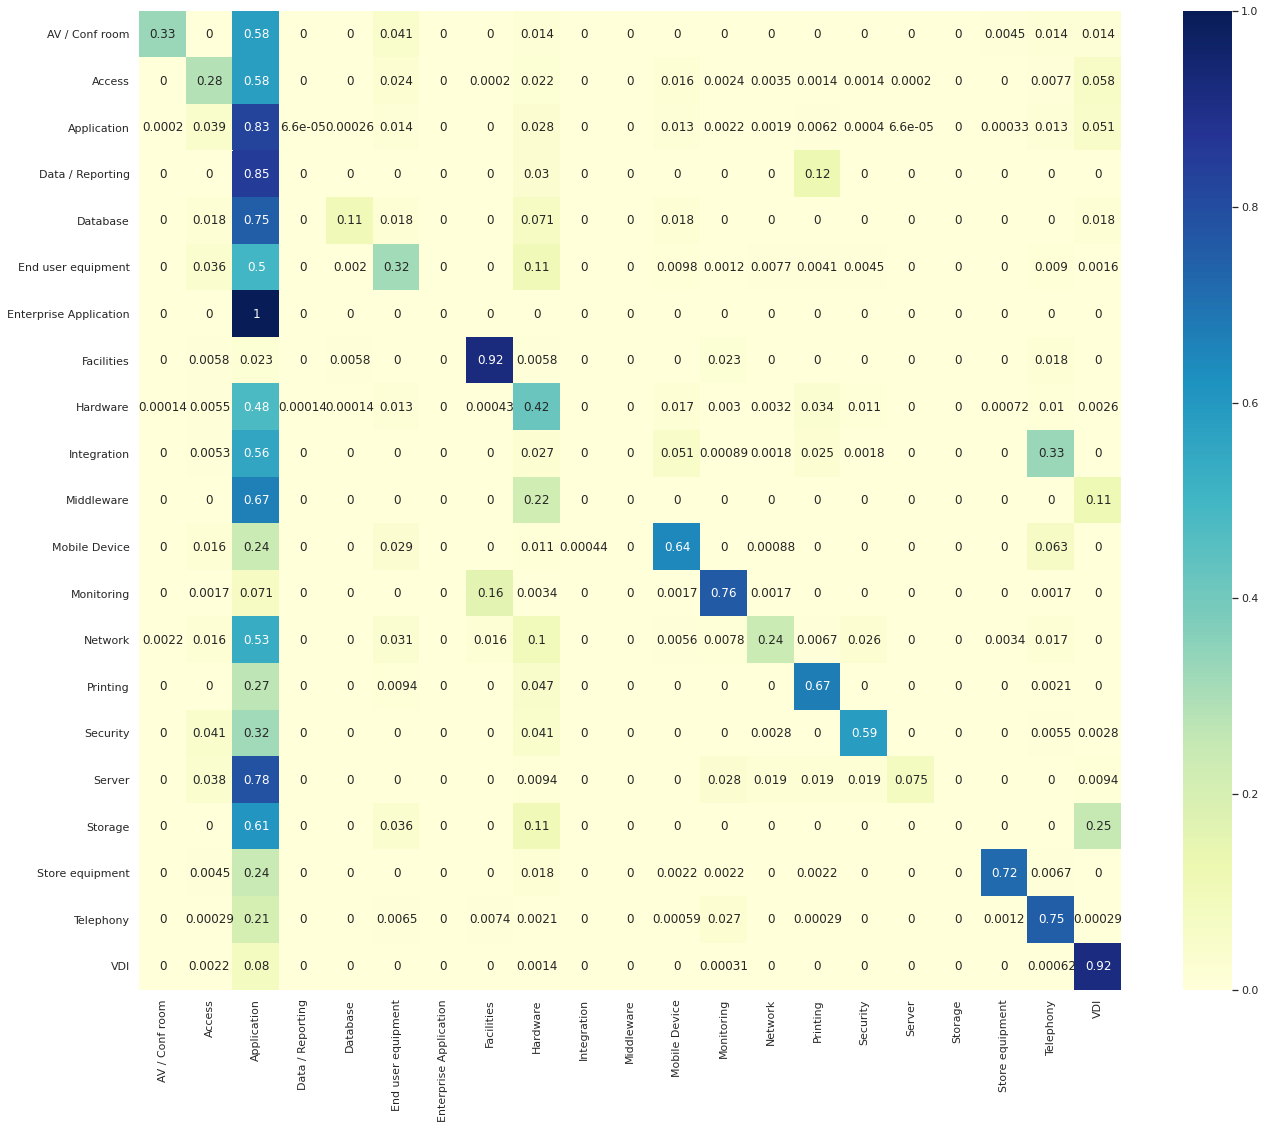

In [ ]:
labels = list(df2['category'].unique())
labels.sort()
cm=metrics.confusion_matrix(y_test, y_pred)
cm = cm / np.sum(cm, axis=1)[:,None]
fig_size=(22,18)
sns.set(rc={'figure.figsize':fig_size})
sns.heatmap(cm, 
    xticklabels=labels,
    yticklabels=labels,
        annot=True, cmap = 'YlGnBu')
plt.pause(0.05)

##Improvement Analysis


In [ ]:
!pip install unidecode

import numpy as np 
import pandas as pd 


import os

import warnings  
warnings.filterwarnings('ignore')

# importing packages
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn packages
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier

# nltk packages
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation
import unidecode


#import os
#from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.feature_extraction.text import CountVectorizer
#import spacy
#import string
#import re
from google.colab import drive 
# import numpy as np
# import pandas as pd
# import plotly.express as px
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
#import nltk
#import operator
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = stopwords.words('english')
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/Shared drives/Capstone Team 15 Drive/Work/')


     |████████████████████████████████| 245kB 10.9MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Mounted at /content/drive


In [ ]:
df = pd.read_csv("incident_download_Capstone_Project_2021-03-01.csv", encoding="ISO-8859-1")
df.head()

,u_affected_application,sys_created_on,resolved_at,calendar_duration,state,impact,urgency,priority,description,short_description,u_knowledge_id.u_ci_class,category,reopen_count,reassignment_count,comments_and_work_notes,u_ci_class_name,cause,close_notes,Unnamed: 18,1
0,Cisco AnyConnect,1/31/2021 23:56,2/1/2021 3:58,14580,Closed,4 - Minor,4 - Low,5 - Very Low,NaN,getting repeted sign-in dialogs in browser and...,NaN,Application,0,0,02-08-2021 04:34:31 - System (Additional comme...,Business Application,NaN,User connected to IDC two factor VPN and getti...,NaN,2
1,Driver,1/31/2021 23:54,2/1/2021 3:35,13287,Closed,4 - Minor,4 - Low,5 - Very Low,NaN,Wifi adapter not connecting to network.,NaN,Application,0,0,02-08-2021 04:33:30 - System (Additional comme...,Business Application,NaN,As taken remote we found WIFI drivers and BIOS...,NaN,3
2,Cisco AnyConnect,1/31/2021 23:53,2/1/2021 1:07,4509,Closed,4 - Minor,4 - Low,5 - Very Low,NaN,When im not on vpn my wifi speed is 40-50 Mbps...,NaN,Application,0,0,02-08-2021 01:36:40 - System (Additional comme...,Business Application,NaN,Requested user to use different Gateway of VPN...,NaN,4
3,Cisco AnyConnect,1/31/2021 23:48,2/1/2021 0:00,804,Closed,4 - Minor,4 - Low,5 - Very Low,NaN,"Lost me vpn google Authenticator key , how can...",NaN,Application,0,0,02-08-2021 00:33:09 - System (Additional comme...,Business Application,NaN,Google Authenticator enrolled,NaN,5
4,NaN,1/31/2021 23:42,2/1/2021 0:51,4151,Closed,4 - Minor,4 - Low,5 - Very Low,NaN,"Hi Team, I'm opening this service ticket on be...",NaN,Application,0,0,02-01-2021 00:51:27 - Santhosh Balu (Additiona...,Business Application,NaN,Issue resolved after connecting Wec 2 factor VPN,NaN,6


In [ ]:
df2 = df[['category', 'short_description']].dropna()

labels = list(df2['category'].unique())
labels.sort()

In [ ]:
# cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# cm_df.to_csv('confusion matrix of predicting category accuracy.csv')

cm_df = pd.read_csv('confusion matrix of predicting category accuracy.csv') 

In [ ]:
cm_df

,Unnamed: 0,AV / Conf room,Access,Application,Data / Reporting,Database,End user equipment,Enterprise Application,Facilities,Hardware,Integration,Middleware,Mobile Device,Monitoring,Network,Printing,Security,Server,Storage,Store equipment,Telephony,VDI
0,AV / Conf room,0.331818,0.000000,0.581818,0.000000,0.000000,0.040909,0.0,0.000000,0.013636,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.004545,0.013636,0.013636
1,Access,0.000000,0.283652,0.579301,0.000000,0.000000,0.024197,0.0,0.000203,0.022163,0.000000,0.0,0.015860,0.002440,0.003457,0.001423,0.001423,0.000203,0.0,0.000000,0.007727,0.057950
2,Application,0.000199,0.039121,0.830344,0.000066,0.000265,0.014166,0.0,0.000000,0.027934,0.000000,0.0,0.013371,0.002184,0.001853,0.006156,0.000397,0.000066,0.0,0.000331,0.012643,0.050904
3,Data / Reporting,0.000000,0.000000,0.848485,0.000000,0.000000,0.000000,0.0,0.000000,0.030303,0.000000,0.0,0.000000,0.000000,0.000000,0.121212,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,Database,0.000000,0.017857,0.750000,0.000000,0.107143,0.017857,0.0,0.000000,0.071429,0.000000,0.0,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.017857
5,End user equipment,0.000000,0.036297,0.499184,0.000000,0.002039,0.315661,0.0,0.000000,0.108891,0.000000,0.0,0.009788,0.001223,0.007749,0.004078,0.004486,0.000000,0.0,0.000000,0.008972,0.001631
6,Enterprise Application,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
7,Facilities,0.000000,0.005848,0.023392,0.000000,0.005848,0.000000,0.0,0.918129,0.005848,0.000000,0.0,0.000000,0.023392,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.017544,0.000000
8,Hardware,0.000144,0.005476,0.477666,0.000144,0.000144,0.012824,0.0,0.000432,0.421182,0.000000,0.0,0.017147,0.003026,0.003170,0.034294,0.010807,0.000000,0.0,0.000720,0.010231,0.002594
9,Integration,0.000000,0.005319,0.558511,0.000000,0.000000,0.000000,0.0,0.000000,0.026596,0.000000,0.0,0.051418,0.000887,0.001773,0.024823,0.001773,0.000000,0.0,0.000000,0.328901,0.000000


In [ ]:
confusion_values = []

for i in range(len(cm_df)):
  confusion_values.append(cm_df.iloc[i,i+1])

confusion_values

prediction_accuracy = pd.DataFrame(confusion_values, index=labels)
prediction_accuracy

,0
AV / Conf room,0.331818
Access,0.283652
Application,0.830344
Data / Reporting,0.000000
Database,0.107143
End user equipment,0.315661
Enterprise Application,0.000000
Facilities,0.918129
Hardware,0.421182
Integration,0.000000


In [ ]:
df['reassignment_binary'] = df['reassignment_count']

def count_to_binary(i):
  if i > 0:
    return 0 
  
  else:
    return 1 # this is deliberately counterintuitive - we want 1 to represent when there is no reassignment, the category was interpreted correctly

df['reassignment_binary'] = df['reassignment_binary'].apply(count_to_binary)

reassignment_accuracy = df.groupby("category")[["reassignment_binary"]].mean()

reassignment_accuracy

,reassignment_binary
category,
AV / Conf room,0.794379
Access,0.685332
Application,0.708127
Data / Reporting,0.460000
Database,0.580110
End user equipment,0.685220
Enterprise Application,0.000000
Facilities,0.034286
Hardware,0.541351


In [ ]:
accuracy_comparison = pd.concat([reassignment_accuracy,prediction_accuracy], join='outer', axis=1)

accuracy_comparison

,reassignment_binary,0
category,,
AV / Conf room,0.794379,0.331818
Access,0.685332,0.283652
Application,0.708127,0.830344
Data / Reporting,0.460000,0.000000
Database,0.580110,0.107143
End user equipment,0.685220,0.315661
Enterprise Application,0.000000,0.000000
Facilities,0.034286,0.918129
Hardware,0.541351,0.421182


In [ ]:
accuracy_comparison_filtered = accuracy_comparison[accuracy_comparison[0] > accuracy_comparison['reassignment_binary']]

In [ ]:
accuracy_comparison_filtered


,reassignment_binary,0
category,,
Application,0.708127,0.830344
Facilities,0.034286,0.918129
Mobile Device,0.524149,0.644592
Monitoring,0.132817,0.758503
Printing,0.397396,0.672251
Store equipment,0.580238,0.721348
Telephony,0.449629,0.749558
VDI,0.784330,0.915083


In [ ]:
accuracy_comparison_filtered.rename(columns={0:"accuracy"},inplace=True)

accuracy_comparison_filtered

,reassignment_binary,accuracy
category,,
Application,0.708127,0.830344
Facilities,0.034286,0.918129
Mobile Device,0.524149,0.644592
Monitoring,0.132817,0.758503
Printing,0.397396,0.672251
Store equipment,0.580238,0.721348
Telephony,0.449629,0.749558
VDI,0.784330,0.915083


In [ ]:
accuracy_comparison_filtered['improvement'] = accuracy_comparison_filtered['accuracy']/accuracy_comparison_filtered['reassignment_binary']

accuracy_comparison_filtered

,reassignment_binary,accuracy,improvement
category,,,
Application,0.708127,0.830344,1.172591
Facilities,0.034286,0.918129,26.778752
Mobile Device,0.524149,0.644592,1.229787
Monitoring,0.132817,0.758503,5.710899
Printing,0.397396,0.672251,1.691639
Store equipment,0.580238,0.721348,1.243194
Telephony,0.449629,0.749558,1.667059
VDI,0.784330,0.915083,1.166706


In [ ]:
for_tableau = pd.read_excel("for_tableau_2.xlsx")

for_tableau['calendar_duration'] = df['calendar_duration']

In [ ]:
for_regression = for_tableau[['category','reassignment_count','hour','calendar_duration']]

for_regression

chosen_categories = list(accuracy_comparison_filtered.index.unique())

for_regression = for_regression[for_regression['category'].isin(chosen_categories)]

In [ ]:
def improvement_value(cat):
  return accuracy_comparison_filtered.loc[cat,'improvement']

for_regression['improvement'] = for_regression['category'].apply(improvement_value)

for_regression['reduced reassignment_count'] = for_regression['reassignment_count'] / for_regression['improvement']

for_regression

,category,reassignment_count,hour,calendar_duration,improvement,reduced reassignment_count
0,Application,0,23,14580,1.172591,0.000000
1,Application,0,23,13287,1.172591,0.000000
2,Application,0,23,4509,1.172591,0.000000
3,Application,0,23,804,1.172591,0.000000
4,Application,0,23,4151,1.172591,0.000000
...,...,...,...,...,...,...
141027,VDI,2,1,813941,1.166706,1.714228
141028,VDI,1,1,203002,1.166706,0.857114
141029,VDI,0,1,164,1.166706,0.000000
141030,VDI,0,0,70529,1.166706,0.000000


In [ ]:
pooled_by_hrs = pd.read_excel('regression results_pooled_hours.xlsx')
pooled_by_hrs.set_index('Category', inplace=True)

# the "Unnamed: 1" column comes from an R regression of duration on reassignment count for combinations of category and hour
# the R code outputs the coefficients into a txt file, and then I hand-copied the coefficient values for all those combinations
# and averaged all the significant and positive ones by hours to get the below results

In [ ]:
for_regression['reassignment_count reduction amount'] = for_regression['reassignment_count'] - for_regression['reduced reassignment_count']

def reassignment_to_duration_coefficient(cat):
  return pooled_by_hrs.loc[cat,'Unnamed: 1']

for_regression['reassignment_to_duration_coefficient'] = for_regression['category'].apply(reassignment_to_duration_coefficient)

for_regression


,category,reassignment_count,hour,calendar_duration,improvement,reduced reassignment_count,reassignment_count reduction amount,reassignment_to_duration_coefficient
0,Application,0,23,14580,1.172591,0.000000,0.000000,451186.125000
1,Application,0,23,13287,1.172591,0.000000,0.000000,451186.125000
2,Application,0,23,4509,1.172591,0.000000,0.000000,451186.125000
3,Application,0,23,804,1.172591,0.000000,0.000000,451186.125000
4,Application,0,23,4151,1.172591,0.000000,0.000000,451186.125000
...,...,...,...,...,...,...,...,...
141027,VDI,2,1,813941,1.166706,1.714228,0.285772,424450.083333
141028,VDI,1,1,203002,1.166706,0.857114,0.142886,424450.083333
141029,VDI,0,1,164,1.166706,0.000000,0.000000,424450.083333
141030,VDI,0,0,70529,1.166706,0.000000,0.000000,424450.083333


In [ ]:
for_regression['reduced calendar_duration'] = for_regression['calendar_duration'] - \
for_regression['reassignment_count reduction amount'] * for_regression['reassignment_to_duration_coefficient']

In [ ]:
for_regression

,category,reassignment_count,hour,calendar_duration,improvement,reduced reassignment_count,reassignment_count reduction amount,reassignment_to_duration_coefficient,reduced calendar_duration
0,Application,0,23,14580,1.172591,0.000000,0.000000,451186.125000,14580.000000
1,Application,0,23,13287,1.172591,0.000000,0.000000,451186.125000,13287.000000
2,Application,0,23,4509,1.172591,0.000000,0.000000,451186.125000,4509.000000
3,Application,0,23,804,1.172591,0.000000,0.000000,451186.125000,804.000000
4,Application,0,23,4151,1.172591,0.000000,0.000000,451186.125000,4151.000000
...,...,...,...,...,...,...,...,...,...
141027,VDI,2,1,813941,1.166706,1.714228,0.285772,424450.083333,692645.030453
141028,VDI,1,1,203002,1.166706,0.857114,0.142886,424450.083333,142354.015226
141029,VDI,0,1,164,1.166706,0.000000,0.000000,424450.083333,164.000000
141030,VDI,0,0,70529,1.166706,0.000000,0.000000,424450.083333,70529.000000


In [ ]:
category_tickets_breakdown = df.groupby("category")[["comments_and_work_notes"]].count() # display count of tickets for each category

total_tickets = category_tickets_breakdown['comments_and_work_notes'].sum()
relevant_categories_tickets = category_tickets_breakdown[category_tickets_breakdown.index.isin(chosen_categories)]['comments_and_work_notes'].sum()

proportion_tickets_relevant = relevant_categories_tickets / total_tickets

proportion_tickets_relevant

0.6287016592237077

In [ ]:
for_regression.to_csv('predict duration.csv') 
for_regression.to_excel('predict duration.xlsx')

In [ ]:
# X = for_regression[['category','reassignment_count','hour']]
# y = for_regression['calendar_duration']

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(interaction_only=True,include_bias = False)
# poly.fit_transform(X)

# without cv tfidf

In [ ]:
# clf = XGBClassifier(random_state=42, objective="softmax")

In [ ]:
# param_grid = {
#      'clf__n_estimators': [50,100,300]
#      #'lambda': 
#      #'clf__colsample_bytree': [0.6,0.8,1]
#      #'clf__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
# }

# grid_search = GridSearchCV(estimator = clf, cv = 3, param_grid = param_grid)

In [ ]:
# grid_search.fit(x_train, y_train)

In [ ]:
# grid_search.best_params_
# clf_test = grid_search.best_estimator_

In [ ]:
# preds = clf_test.predict(x_test)

In [ ]:
# metrics.accuracy_score(y_test, preds)

In [ ]:
# print(metrics.classification_report(y_test, preds))

In [ ]:
# labels = df2['category'].unique()
# cm=metrics.confusion_matrix(y_test, preds)
# cm = cm / np.sum(cm, axis=1)[:,None]
# fig_size=(22,18)
# sns.set(rc={'figure.figsize':fig_size})
# sns.heatmap(cm, 
#     xticklabels=labels,
#     yticklabels=labels,
#         annot=True, cmap = 'YlGnBu')
# plt.pause(0.05)

# Catboost

In [ ]:
# pip install catboost

In [ ]:
# from catboost import CatBoostClassifier, Pool

In [ ]:
# train, test = train_test_split(df2, test_size = 0.33, random_state=42)
# X = train.drop(['category'], axis=1)
# y = train['category']
# x_train, x_valid, y_train, y_valid = train_test_split(X,y, test_size=0.3, random_state=42)

# x_test = test.drop(['category'], axis=1)
# y = test['category']

In [ ]:
# text_features = ['short_description']
# train_pool = Pool(
#     x_train,
#     y_train,
#     text_features = text_features,
#     feature_names = list(x_train)
# )


# valid_pool = Pool(
#     x_valid,
#     y_valid,
#     text_features = text_features,
#     feature_names = list(x_valid)
# )

# catboost_params = {
#     'iterations': 3000,
#     'learning_rate': 0.01,
#     'eval_metric': 'AUC',
#     'early_stopping_rounds': 1000,
#     'od_type': 'Iter',
#     'use_best_model': True
# }

# cmodel = CatBoostClassifier(**catboost_params)

In [ ]:
# #text_features = [0]
# cmodel.fit(train_pool, eval_set=valid_pool, plot=True)

In [ ]:
# y_pred = cmodel.predict(x_test)

In [ ]:
# metrics.accuracy_score(y, y_pred)

In [ ]:
# print(metrics.classification_report(y, y_pred))

In [ ]:
# labels = df2['category'].unique()
# cm=metrics.confusion_matrix(y, y_pred)
# cm = cm / np.sum(cm, axis=1)[:,None]
# fig_size=(22,18)
# sns.set(rc={'figure.figsize':fig_size})
# sns.heatmap(cm, 
#     xticklabels=labels,
#     yticklabels=labels,
#         annot=True, cmap = 'BuPu')
# plt.pause(0.05)

In [ ]:
# from sklearn.externals import joblib
# joblib.dump(cmodel, 'catboost1.pkl')

# Undersampling

In [ ]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline

In [ ]:
# dic = {}
# for i in df2['category']:
#   dic[i] = 20

# over = SMOTE(sampling_strategy=dic)
# #under = RandomUnderSampler(sampling_strategy=dic)
# steps = [('o', over), ('u', under)]
# pipeline = Pipeline(steps=steps)

In [ ]:
# x_train,y_train = over.fit_resample(x_train,y_train)